In [6]:
import uproot as ur
import matplotlib.pyplot as plt
import statistics
import k3d
import numpy as np
import awkward as ak
import mplhep as hep
import matplotlib.colors as mcolors
from scipy.stats import norm
import scipy
from scipy.optimize import curve_fit

In [28]:
#Open root file
input_file = 'rec_cal_output.edm4hep.root '
events = ur.open("%s:events"%(input_file))
arrays = events.arrays()

#gather arrays of reconstructed hits data
recoenergy = arrays['HcalEndcapPInsertHitsReco.energy']
recotime = arrays['HcalEndcapPInsertHitsReco.time']
recox = arrays['HcalEndcapPInsertHitsReco.position.x']
recoy = arrays['HcalEndcapPInsertHitsReco.position.y']
recoz = arrays['HcalEndcapPInsertHitsReco.position.z']

#Create 1D arrays for reconstructed hit data
RecoEventEnergies = []
RecoHitEnergies = []
RecoTimes = []
RecoXpos = []
RecoYpos = []
RecoZpos = []

#Gather arrays of generated primary particles
cut_primary = arrays["MCParticles.generatorStatus"]==1
px = arrays['MCParticles.momentum.x'][cut_primary]
py = arrays['MCParticles.momentum.y'][cut_primary]
pz = arrays['MCParticles.momentum.z'][cut_primary]
mass = arrays["MCParticles.mass"][cut_primary]

#Calculate generated primary particle properties
mom = np.sqrt(px**2+py**2+pz**2)
energy = np.sqrt(mom**2+mass**2)
fig = plt.figure( figsize=(8, 6))
phi = np.arctan2(py,px)

#Create 1D arrays for generated primary particles data
GenEnergies = []
Phis = []

#Create 1D arrays for other calculated variables
EnergyResolution = []

for i in range(len(energy)):
    GenEnergies.append(energy[i][0])

#Loop over all events
#for i in range(len(recoenergy)):
for i in range(2000):   
    #Reset all calculated event-level calculations
    EventEnergy = 0
    
    #Loop over all hits within an event
    for j in range(len(recoenergy[i])):
        if recoenergy[i][j] < 0:
            print(i)
            print(j)
            print(recoenergy[i][j])
        
        #Apply any hit-level cuts
        if recoenergy[i][j] < 1000 and recoenergy[i][j] > 0.0006 and recotime[i][j] < 200:
            
            #Sum all non-cut hit energies within an event to determine the reconstructed event energy
            EventEnergy += recoenergy[i][j]
            
            #Append hit data to 1D arrays
            RecoXpos.append(recox[i][j])
            RecoYpos.append(recoy[i][j])
            RecoZpos.append(recoz[i][j])
            RecoHitEnergies.append(recoenergy[i][j])
            RecoTimes.append(recotime[i][j])
            
    RecoEventEnergies.append(EventEnergy)        
    #Apply any event-level cuts    

    #Print progress
    if i % 100 == 0:
        print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


<Figure size 576x432 with 0 Axes>

0.04578097107489445
0.45152148563447614


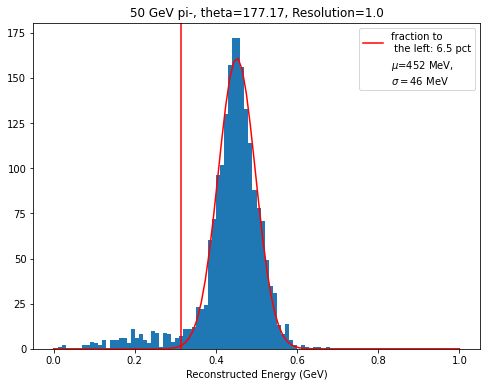

In [41]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 


fig = plt.figure( figsize=(8, 6), facecolor='w')

hist_data, bins, patches = plt.hist(RecoEventEnergies, bins=100, range=[0, 1])

x = np.linspace(0, 1, 100)
y = hist_data
popt, pcov = curve_fit(gaussian, x, y, p0=(100, 0.45, 0.045))

resolution = RecoEventEnergies
y = gaussian(x, *popt)
plt.plot(x, y, color='r')
plt.xlabel('Reconstructed Energy (GeV)')
plt.title('50 GeV pi-, theta=177.17, Resolution=%3.1f'%((popt[2]/popt[1])*10))

numleft = 0
numright = 0
print(popt[2])
print(popt[1])
for i in range(len(RecoEventEnergies)):
    if(RecoEventEnergies[i] < popt[1] - (3 * popt[2])):
        numleft = numleft + 1
    if(RecoEventEnergies[i] > (3 * popt[2]) + popt[1]):
        numright = numright + 1
fraction_outside = 100*(numleft / len(RecoEventEnergies))
plt.axvline(popt[1]-3.0*popt[2],color='red',label='fraction to \n the left: %2.1f pct'%(fraction_outside))

plt.plot([], [], ' ', label='$\mu$=%2.0f MeV, \n$\sigma=$%2.0f MeV'%(popt[1]*1000,popt[2]*1000))

plt.legend()

plt.show()

Fitted mean 451.9 MeV
Fitted standard deviation 45.7 MeV 
Resolution = 10.1 
6.55


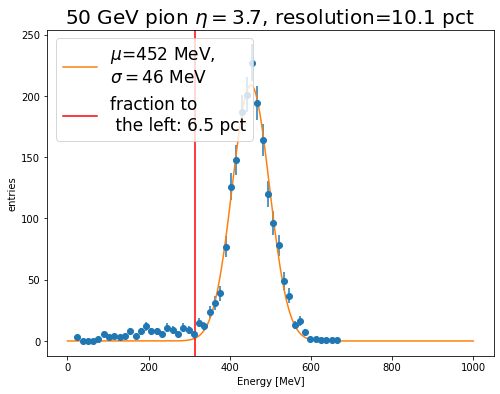

In [46]:
import numpy as np
from scipy.optimize import curve_fit
energy = []
for i in range(len(RecoEventEnergies)):
    energy.append(1000*RecoEventEnergies[i])

hist, bin_edges = np.histogram(np.array(energy),bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
p0 = [1000., 500., 50.]
coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
hist_fit = gauss(np.linspace(0,1000,1000), *coeff)
fig = plt.figure( figsize=(8, 6))

plt.errorbar(bin_centres, y=hist, yerr=np.sqrt(hist),fmt='o')
plt.plot(np.linspace(0,1000,1000), hist_fit, label='$\mu$=%2.0f MeV, \n$\sigma=$%2.0f MeV'%(coeff[1],coeff[2]))

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print ('Fitted mean %2.1f MeV'%coeff[1])
print ('Fitted standard deviation %2.1f MeV '%coeff[2])
print('Resolution = %2.1f '%(100*coeff[2]/coeff[1]))

plt.xlabel('Energy [MeV]')
plt.ylabel('entries')

mask  = bin_centres < coeff[1]-3.0*coeff[2]
fraction_outside = 100.0*np.sum(hist[mask])/np.sum(hist)
print(fraction_outside)
plt.axvline(coeff[1]-3.0*coeff[2],color='red',label='fraction to \n the left: %2.1f pct'%(fraction_outside))


plt.title('50 GeV pion $\eta=3.7$, resolution=%2.1f pct'%(100*coeff[2]/coeff[1]),fontsize=20)
plt.legend(fontsize=17,loc='upper left')

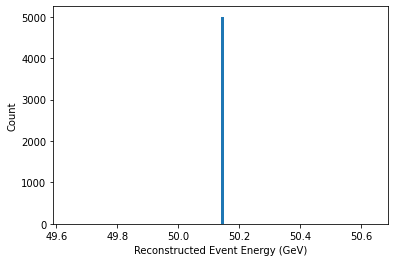

In [18]:
#Plot reco energy histogram
plt.hist(GenEnergies, bins=100)
plt.xlabel('Reconstructed Event Energy (GeV)')
plt.ylabel('Count')
plt.show()

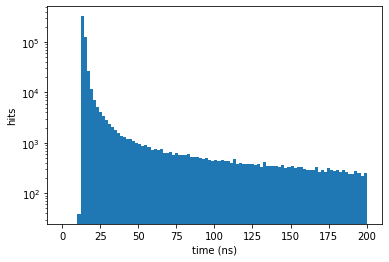

In [19]:
#Plot hit time histogram
plt.hist(RecoTimes,bins=100, range=(0,200),label='HCAL')
plt.yscale('log')
plt.xlabel('time (ns)')
plt.ylabel('hits')
plt.show()

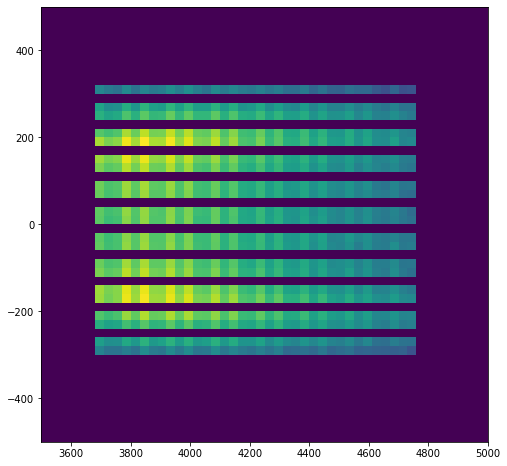

In [13]:
#Plot Z Y hit distribution
fig = plt.figure( figsize=(8, 8))
plt.hist2d(RecoZpos,RecoYpos,bins=50, range=([3500,5000],[-500,500]),norm=mcolors.PowerNorm(0.2))
plt.show()